In [51]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
import CategoricalEncoder as ce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def read_file(x):
    df=pd.read_csv(x)
    return df
def categories(x,y,z):
    categories = x // y
    categories[categories >= z]= z
    return categories
def st_split(x,y):
    split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for training_indices, test_indices in split.split(x,y):
        stratified_train_set = housing.loc[training_indices]
        stratified_test_set = housing.loc[test_indices]
    return stratified_train_set,stratified_test_set
def features_labels_numeric(x):
    features = x.drop('median_house_value', axis=1)
    labels = x['median_house_value'].copy()
    numeric = features.drop('ocean_proximity', axis=1)
    return features,labels,numeric
def read_cols(x):
    numeric_cols = list(x)
    categorical_cols = ['ocean_proximity']
    return numeric_cols,categorical_cols
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_names].values
rooms_col, bedrooms_col, population_col, households_col = 3, 4, 5, 6
def my_pipeline(x,y):
    numeric_cols_pipeline = Pipeline([('selector', ColumnSelector(x)),
                                  ('imputer', Imputer(strategy='median')),
                                  ('standard_scaler', StandardScaler())
                                 ])
    categorical_cols_pipeline = Pipeline([('selector', ColumnSelector(y)),
                                      ('encoder', ce.CategoricalEncoder(encoding='onehot-dense'))
                                     ])
    full_pipeline = FeatureUnion(transformer_list=[('numeric_pipeline', numeric_cols_pipeline),
                                               ('categorical_pipeline', categorical_cols_pipeline)
                                              ])
    return full_pipeline

In [ ]:
housing=read_file('housing.csv')
def per_household(X):
    X['rooms_per_household'] = X.total_rooms / X.households
    X['bedrooms_per_household'] = X.total_bedrooms / X.households
    X['bedrooms_per_room'] = X.total_bedrooms / X.total_rooms
    X['population_per_household'] = X.population / X.households
    return X
a=housing['ocean_proximity']
corr_matrix2 = per_household(housing).corr()
corr_matrix2 = np.abs(corr_matrix2)
x=(corr_matrix2.median_house_value.sort_values(ascending=False).index).tolist()
x=x[:5]

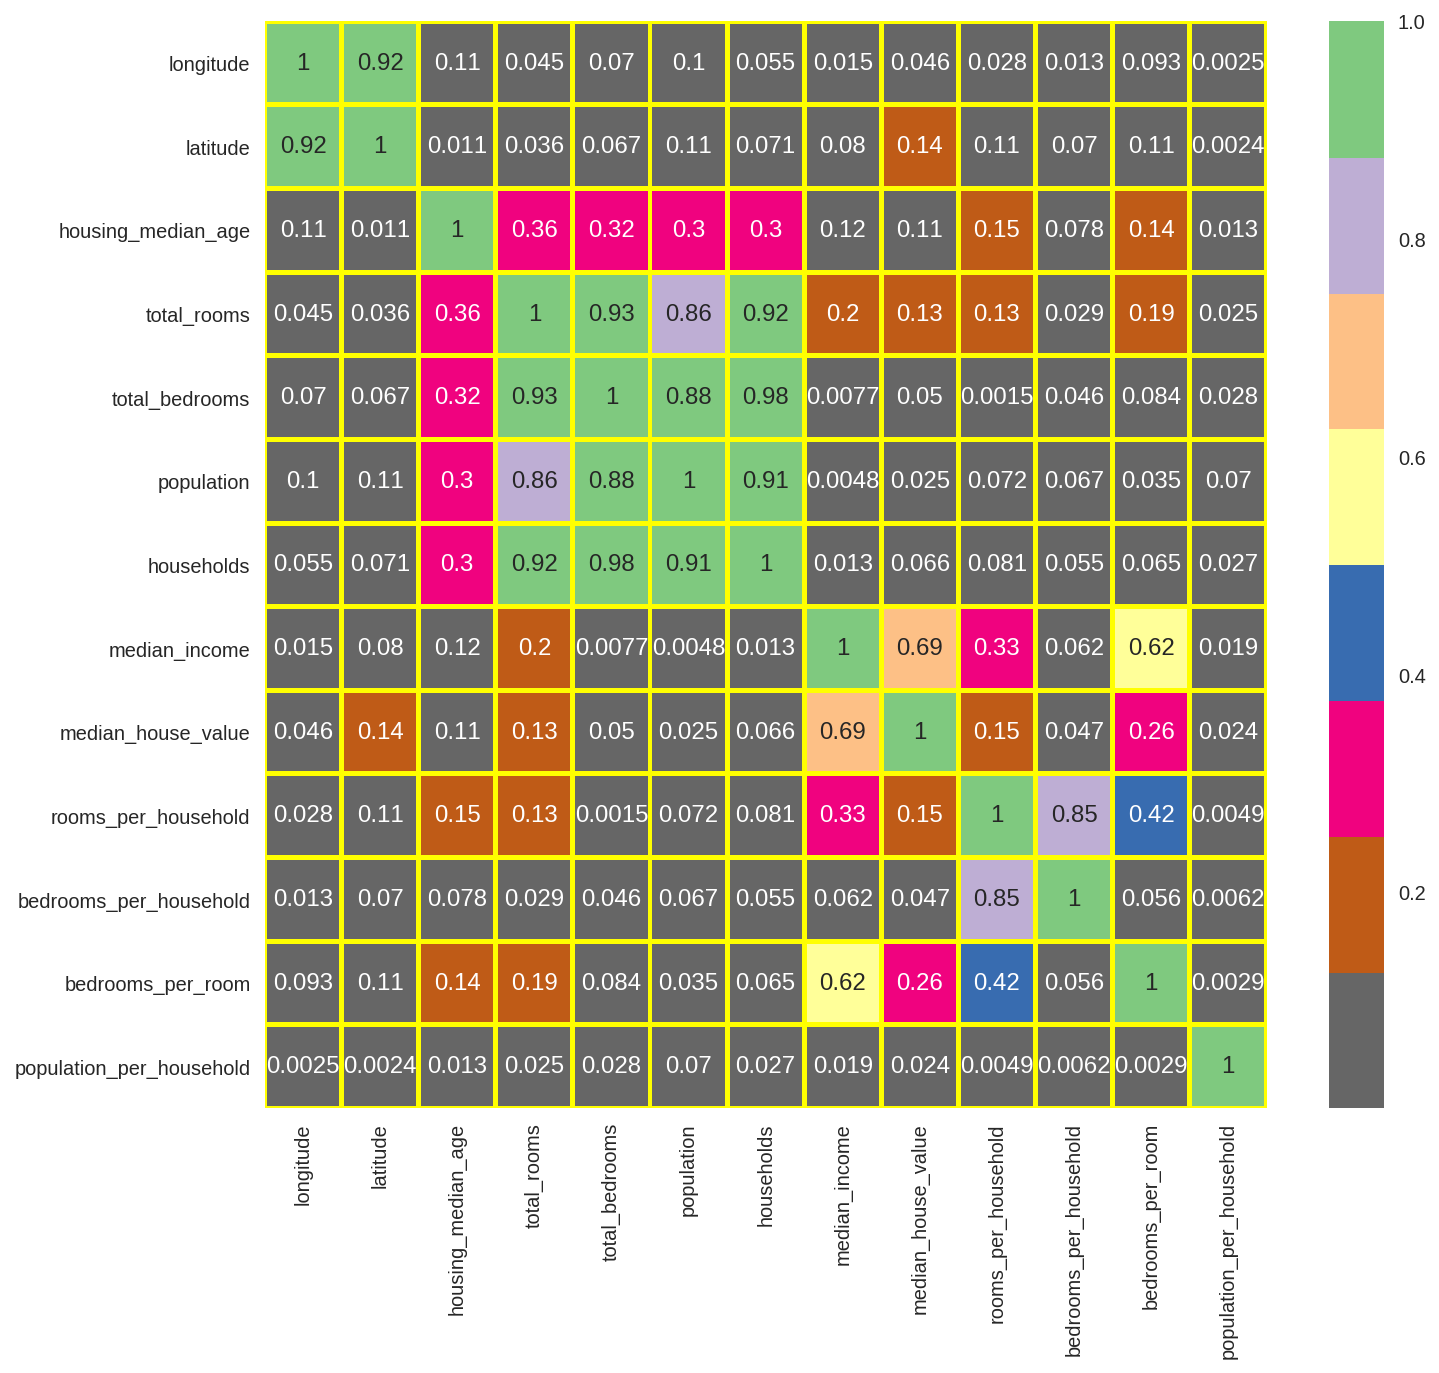

In [53]:
x=sns.set(rc={'figure.figsize':(10,10)})
x=sns.heatmap(corr_matrix2, vmin=None, vmax=None, cmap='Accent_r', center=None, robust=False, 
            annot=True, fmt='.2g', annot_kws=None, linewidths=2, linecolor='yellow', cbar=True,
            cbar_kws=None, cbar_ax=None, square=False, ax=None, xticklabels=True, yticklabels=True, mask=None)

In [38]:
housing=housing[x]
housing=pd.concat([housing,a],axis=1)
income_categories=categories(housing['median_income'],1.5,5)
stratified_train_set,stratified_test_set=st_split(housing, income_categories)
housing_features,housing_labels,housing_numeric=features_labels_numeric(stratified_train_set)
numeric_cols,categorical_cols=read_cols(housing_numeric)
housing_transformed = my_pipeline(numeric_cols,categorical_cols).fit_transform(stratified_train_set)

In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
rf_reg = RandomForestRegressor()
x = rf_reg.fit(housing_transformed, housing_labels)

housing_predictions3 = rf_reg.predict(housing_transformed)
train_mse3 = mean_squared_error(housing_labels, housing_predictions3)
np.sqrt(train_mse3)
r2_score(housing_labels, housing_predictions3)

27608.743501631881

0.94256157427124398

In [40]:
scores3 = cross_val_score(rf_reg, housing_transformed, housing_labels, scoring='neg_mean_squared_error', cv=10)
train_mse33_scores = np.sqrt(-scores3)
print(train_mse33_scores.mean())
print(train_mse33_scores.std())

65703.805044
1495.30718546
